## Dataset
You can find the dataset in the data folder of the repository. The folder contains two files:
* dow_jones_index.data - dataset data
* dow_jones_index.names - dataset information and details

## Problem 

At the start of every week you have 100$ to buy a stock and you have to sell it by the end of the week. Predict which one is going to perform better.

## Business Analysis

The Dow Jones Industrial Average (DJIA) is one of the most widely recognized stock market indices in the world. It represents the performance of 30 large, publicly traded companies listed on stock exchanges in the United States. 

Based on the dataset variables provided, here are some main topics to consider for analyzing the Dow Jones Index:

Price and Volume Data: The dataset includes various price-related variables such as open, high, low, and close prices, as well as volume, which represents the number of shares traded. Analyzing these variables can provide information about the weekly price movements and trading activity of the index.

Percentage Changes: The dataset includes variables for percentage changes in price (percent_change_price) and volume (percent_change_volume_over_last_week). These metrics help measure the rate of change in stock prices and trading volume, which can indicate market trends and investor sentiment.

Dividend Information: The dataset includes variables such as days_to_next_dividend and percent_return_next_dividend, which provide insights into the dividend payments made by the Dow Jones Index component companies. Dividends are a portion of a company's profits distributed to shareholders and can influence investor decisions.


## Data Understanding

The way to think about the problem is through a regression to calculate the 'percent_change_next_weeks_price' through the features used. A small script will then be used that, for each date, will choose the stock with the best return, filtered by the given budget. Initially, and analyzing the statement, the 'next_weeks_close' feature will be excluded, as it was not known at the time of purchase at the beginning of the week.

There are 30 lines with missing values in 2 columns, which correspond to the first week of each 'stock' that will be deleted, although we could use some kind of imputation.

Due to the fact that we have few entries, the use of an encoding in the 'stock' can lead to overfiting, so a 'sector' feature will be used instead.

For a more complete forecast system we could decompose the date into day, month and year, in this case it doesn't seem to make sense as we are always talking about the same year, so it will be eliminated.

We are left with 24 entries for each stock, so the split of the dataset will be done in a stratified way for each stock, the first 20 for training and validation and the last 4 for testing.

An overnight price gap column will be created, which will consist of the current week's open minus the previous week's close. Furthermore, it would be interesting to create a weekly volatility measure, but a dataset with more entries would be needed.

In [1]:
#add here your imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf

#### Read dataset, type set, pre-processing and creation of sector feature and percent_overnight_gap

In [2]:
def get_sector(stock_symbol):
    try:
        stock_info = yf.Ticker(stock_symbol)
        sector = stock_info.info.get('sector', 'Unknown')
    except:
        pass
    if stock_symbol == 'UTX' or stock_symbol == 'CAT':
        sector = 'Industrials'
    elif stock_symbol == 'KRFT':
        sector = 'Consumer Defensive'
    return sector

In [ ]:
df = pd.read_csv('../Datasets/dow_jones_index.data')

df['date'] = pd.to_datetime(df['date']) 
columns_to_float = ['open', 'high', 'low', 'close', 'next_weeks_open', 'next_weeks_close']

for c in columns_to_float:
    df[c] = df[c].replace({'\$': ''}, regex=True).astype(float)


for stock in df['stock'].unique():
    sector = get_sector(stock)
    df.loc[df['stock'] == stock, 'sector'] = sector

columns_percents = [x for x in df.columns if x.startswith('percent')]
for c in columns_percents:
    df[c] = df[c] / 100

df['previous_weeks_close'] = df['close'].shift(1)
df.loc[df['date'] == '2011-01-07', 'previous_weeks_close'] = np.nan
df['percent_overnight_gap'] = (df['open'] - df['previous_weeks_close'])/df['previous_weeks_close']

df = df.dropna()

data = df.copy()

Exception


Overview of the data and missing values

In [4]:
data.head()

,quarter,stock,date,open,high,low,close,volume,percent_change_price,percent_change_volume_over_last_wk,previous_weeks_volume,next_weeks_open,next_weeks_close,percent_change_next_weeks_price,days_to_next_dividend,percent_return_next_dividend,sector,previous_weeks_close,percent_overnight_gap
1,1,AA,2011-01-14,16.71,16.71,15.64,15.97,242963398,-0.044285,0.013802,239655616.0,16.19,15.79,-0.024707,19,0.001879,Basic Materials,16.42,0.017661
2,1,AA,2011-01-21,16.19,16.38,15.60,15.79,138428495,-0.024707,-0.430250,242963398.0,15.87,16.13,0.016383,12,0.001900,Basic Materials,15.97,0.013776
3,1,AA,2011-01-28,15.87,16.63,15.82,16.13,151379173,0.016383,0.093555,138428495.0,16.18,17.14,0.059333,5,0.001860,Basic Materials,15.79,0.005066
4,1,AA,2011-02-04,16.18,17.39,16.18,17.14,154387761,0.059333,0.019875,151379173.0,17.33,17.37,0.002308,97,0.001750,Basic Materials,16.13,0.003100
5,1,AA,2011-02-11,17.33,17.48,16.97,17.37,114691279,0.002308,-0.257122,154387761.0,17.39,17.28,-0.006325,90,0.001727,Basic Materials,17.14,0.011085


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 720 entries, 1 to 749
Data columns (total 19 columns):
 #   Column                              Non-Null Count  Dtype         
---  ------                              --------------  -----         
 0   quarter                             720 non-null    int64         
 1   stock                               720 non-null    object        
 2   date                                720 non-null    datetime64[ns]
 3   open                                720 non-null    float64       
 4   high                                720 non-null    float64       
 5   low                                 720 non-null    float64       
 6   close                               720 non-null    float64       
 7   volume                              720 non-null    int64         
 8   percent_change_price                720 non-null    float64       
 9   percent_change_volume_over_last_wk  720 non-null    float64       
 10  previous_weeks_volume     

In [109]:
data.describe()

,quarter,open,high,low,close,volume,percent_change_price,percent_change_volume_over_last_wk,previous_weeks_volume,next_weeks_open,next_weeks_close,percent_change_next_weeks_price,days_to_next_dividend,percent_return_next_dividend,previous_weeks_close,percent_overnight_gap,cumulative_return
count,720.000000,720.000000,720.000000,720.000000,720.000000,7.200000e+02,720.000000,720.000000,7.200000e+02,720.000000,720.000000,720.000000,720.000000,720.000000,720.000000,720.000000,720.000000
mean,1.541667,53.748375,54.764806,52.727875,53.825486,1.156040e+08,0.000301,0.055936,1.173876e+08,53.808500,53.971319,0.001933,52.259722,0.006916,53.734847,0.031910,1.032345
std,0.498607,32.764255,33.357485,32.238065,32.924759,1.520844e+08,0.025049,0.405435,1.592322e+08,32.919751,33.145594,0.026639,45.881968,0.003051,32.781764,0.469260,0.083709
min,1.000000,10.590000,10.940000,10.400000,10.520000,9.718851e+06,-0.154229,-0.614332,9.718851e+06,10.520000,10.520000,-0.154229,0.000000,0.000656,10.520000,-0.876174,0.710642
25%,1.000000,29.965000,30.662500,28.712500,30.415000,3.069225e+07,-0.012974,-0.198043,3.067832e+07,30.385000,30.507500,-0.012524,24.000000,0.005341,30.415000,-0.005028,0.993434
50%,2.000000,46.015000,46.910000,44.950000,46.125000,5.274535e+07,0.000000,0.005126,5.294556e+07,46.040000,45.930000,0.000360,47.000000,0.006801,46.125000,-0.000271,1.040701
75%,2.000000,72.805000,74.340000,71.105000,72.765000,1.311530e+08,0.016309,0.218006,1.333230e+08,72.805000,73.002500,0.017926,69.250000,0.008540,72.622500,0.003800,1.088100
max,2.000000,172.110000,173.540000,167.820000,170.580000,1.054415e+09,0.098822,3.274089,1.453439e+09,172.110000,174.540000,0.098822,329.000000,0.015642,170.580000,9.412548,1.212877


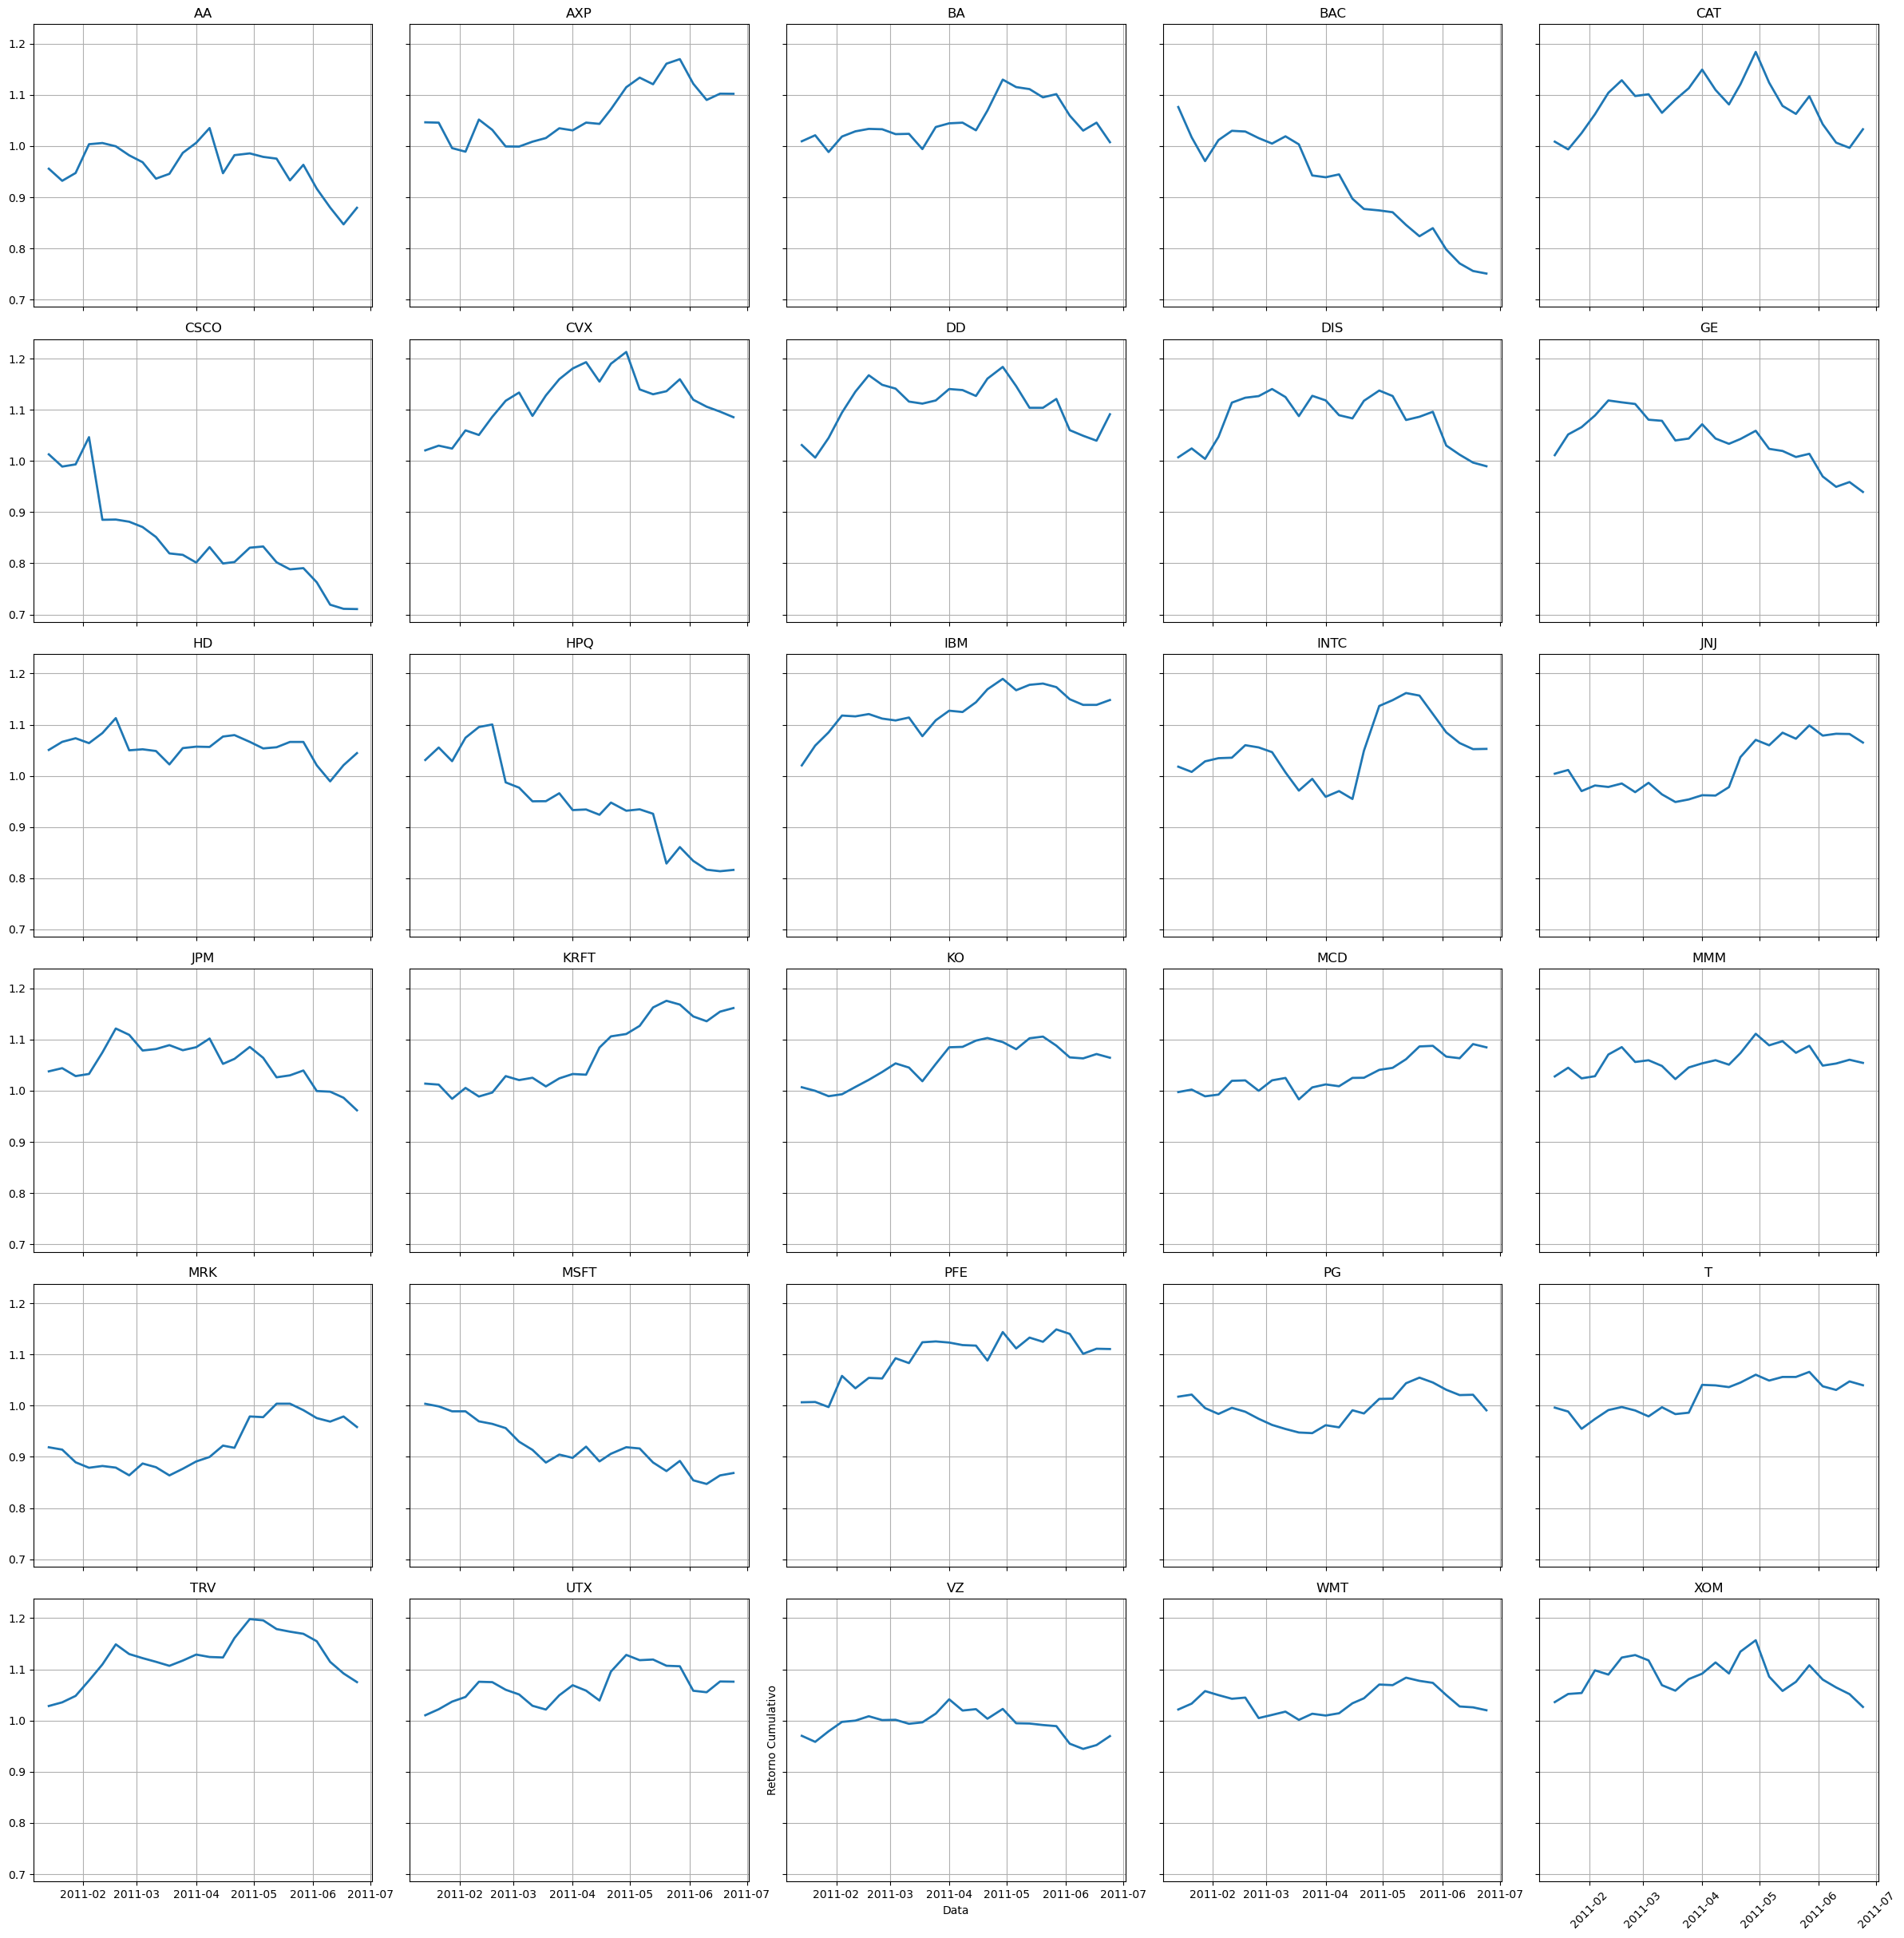

In [6]:
data['cumulative_return'] = 1  

for stock, stock_data in data.groupby('stock'):
    cumulative_return = stock_data['percent_change_price'].add(1).cumprod()
    data.loc[stock_data.index, 'cumulative_return'] = cumulative_return

unique_stocks = data['stock'].unique()
num_plots = len(unique_stocks)
num_cols = 5
num_rows = (num_plots - 1) // num_cols + 1

fig, axs = plt.subplots(num_rows, num_cols, figsize=(24, 4*num_rows), sharex=True, sharey=True)

for i, stock in enumerate(unique_stocks):
    row = i // num_cols
    col = i % num_cols
    stock_data = data[data['stock'] == stock]
    axs[row, col].plot(stock_data['date'], stock_data['cumulative_return'], linewidth=2)
    axs[row, col].set_title(stock)
    axs[row, col].grid(True)


plt.tight_layout()

axs[-1, num_cols//2].set(xlabel='Data', ylabel='Retorno Cumulativo')

plt.xticks(rotation=45)
plt.show()

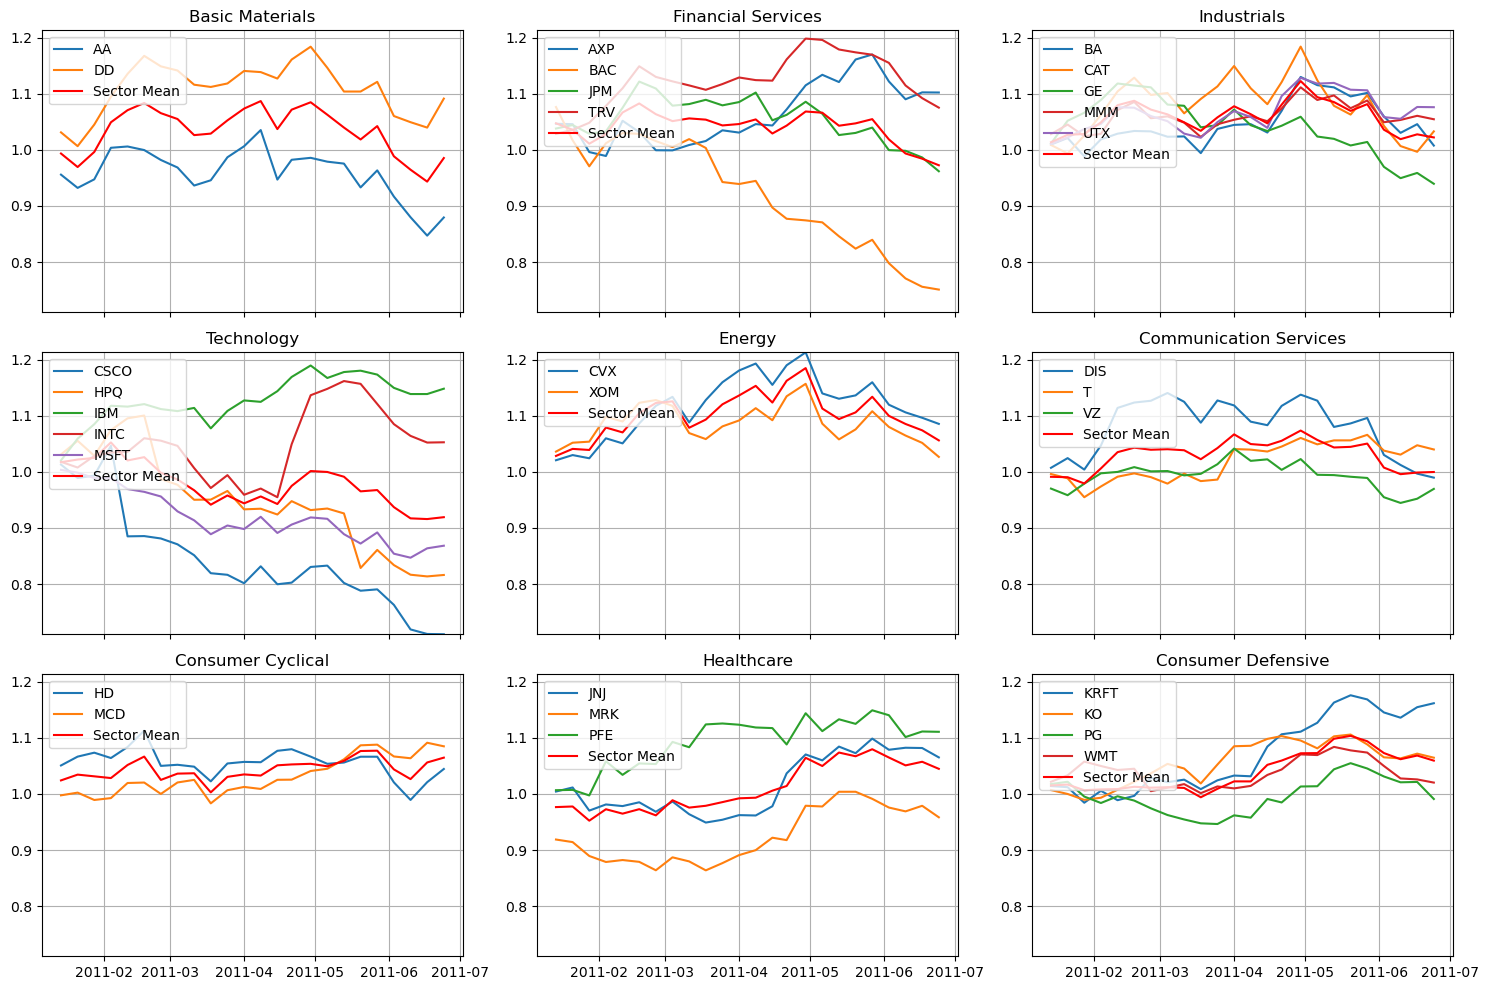

In [ ]:
num_rows = int((len(data['sector'].unique())+2) / 3)
num_cols = 3

fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 10), sharex=True)

for i, sector in enumerate(data['sector'].unique()):
    sector_df = data[data['sector'] == sector]

    row = i // num_cols
    col = i % num_cols

    for stock in sector_df['stock'].unique():
        stock_df = sector_df[sector_df['stock'] == stock]
        axes[row, col].plot(stock_df['date'], stock_df['cumulative_return'], label=stock)
        
    sector_mean = sector_df.groupby('date')['cumulative_return'].mean()
    axes[row, col].plot(sector_mean.index, sector_mean, label='Sector Mean', color='red')
    
    axes[row, col].set_title(sector)
    axes[row, col].legend(loc='upper left')
    
    y_min = data['cumulative_return'].min()
    y_max = data['cumulative_return'].max()
    axes[row, col].set_ylim(y_min, y_max)
    axes[row, col].grid(True)

plt.tight_layout()

plt.show()

C:\Users\joaof\AppData\Local\Temp\ipykernel_19124\1889976440.py:4: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(data.corr(),annot=True,fmt=".2f")


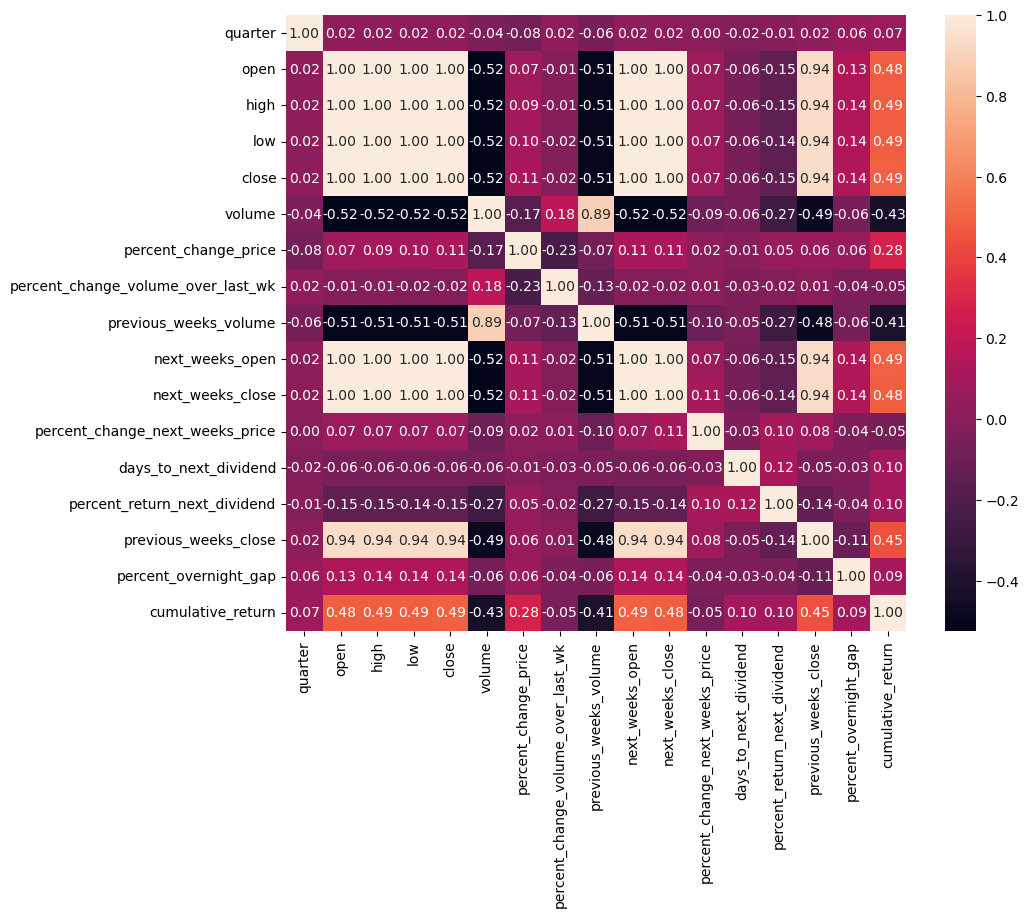

In [8]:
import seaborn as sns

plt.figure(figsize=(10, 8))
sns.heatmap(data.corr(),annot=True,fmt=".2f")
plt.show()


In [9]:
from sklearn.metrics import mutual_info_score
import warnings
warnings.simplefilter(action='ignore', category=UserWarning)

for column in data.columns:
    print(f'{column} -> {mutual_info_score(data["percent_change_next_weeks_price"], data[column])}')

quarter -> 0.6859162516164747
stock -> 3.386266052751921
date -> 3.1677000526404955
open -> 6.512805786326746
high -> 6.495005165043871
low -> 6.495477106812747
close -> 6.497874457416513
volume -> 6.564319883099866
percent_change_price -> 6.549388554189632
percent_change_volume_over_last_wk -> 6.564319883099866
previous_weeks_volume -> 6.564319883099866
next_weeks_open -> 6.509681702189976
next_weeks_close -> 6.504377417454185
percent_change_next_weeks_price -> 6.564319883099866
days_to_next_dividend -> 4.1235557965297245
percent_return_next_dividend -> 6.5320598746756335
sector -> 2.1236817672978625
previous_weeks_close -> 6.497874457416513
percent_overnight_gap -> 6.469871363691696
cumulative_return -> 6.552767430090534


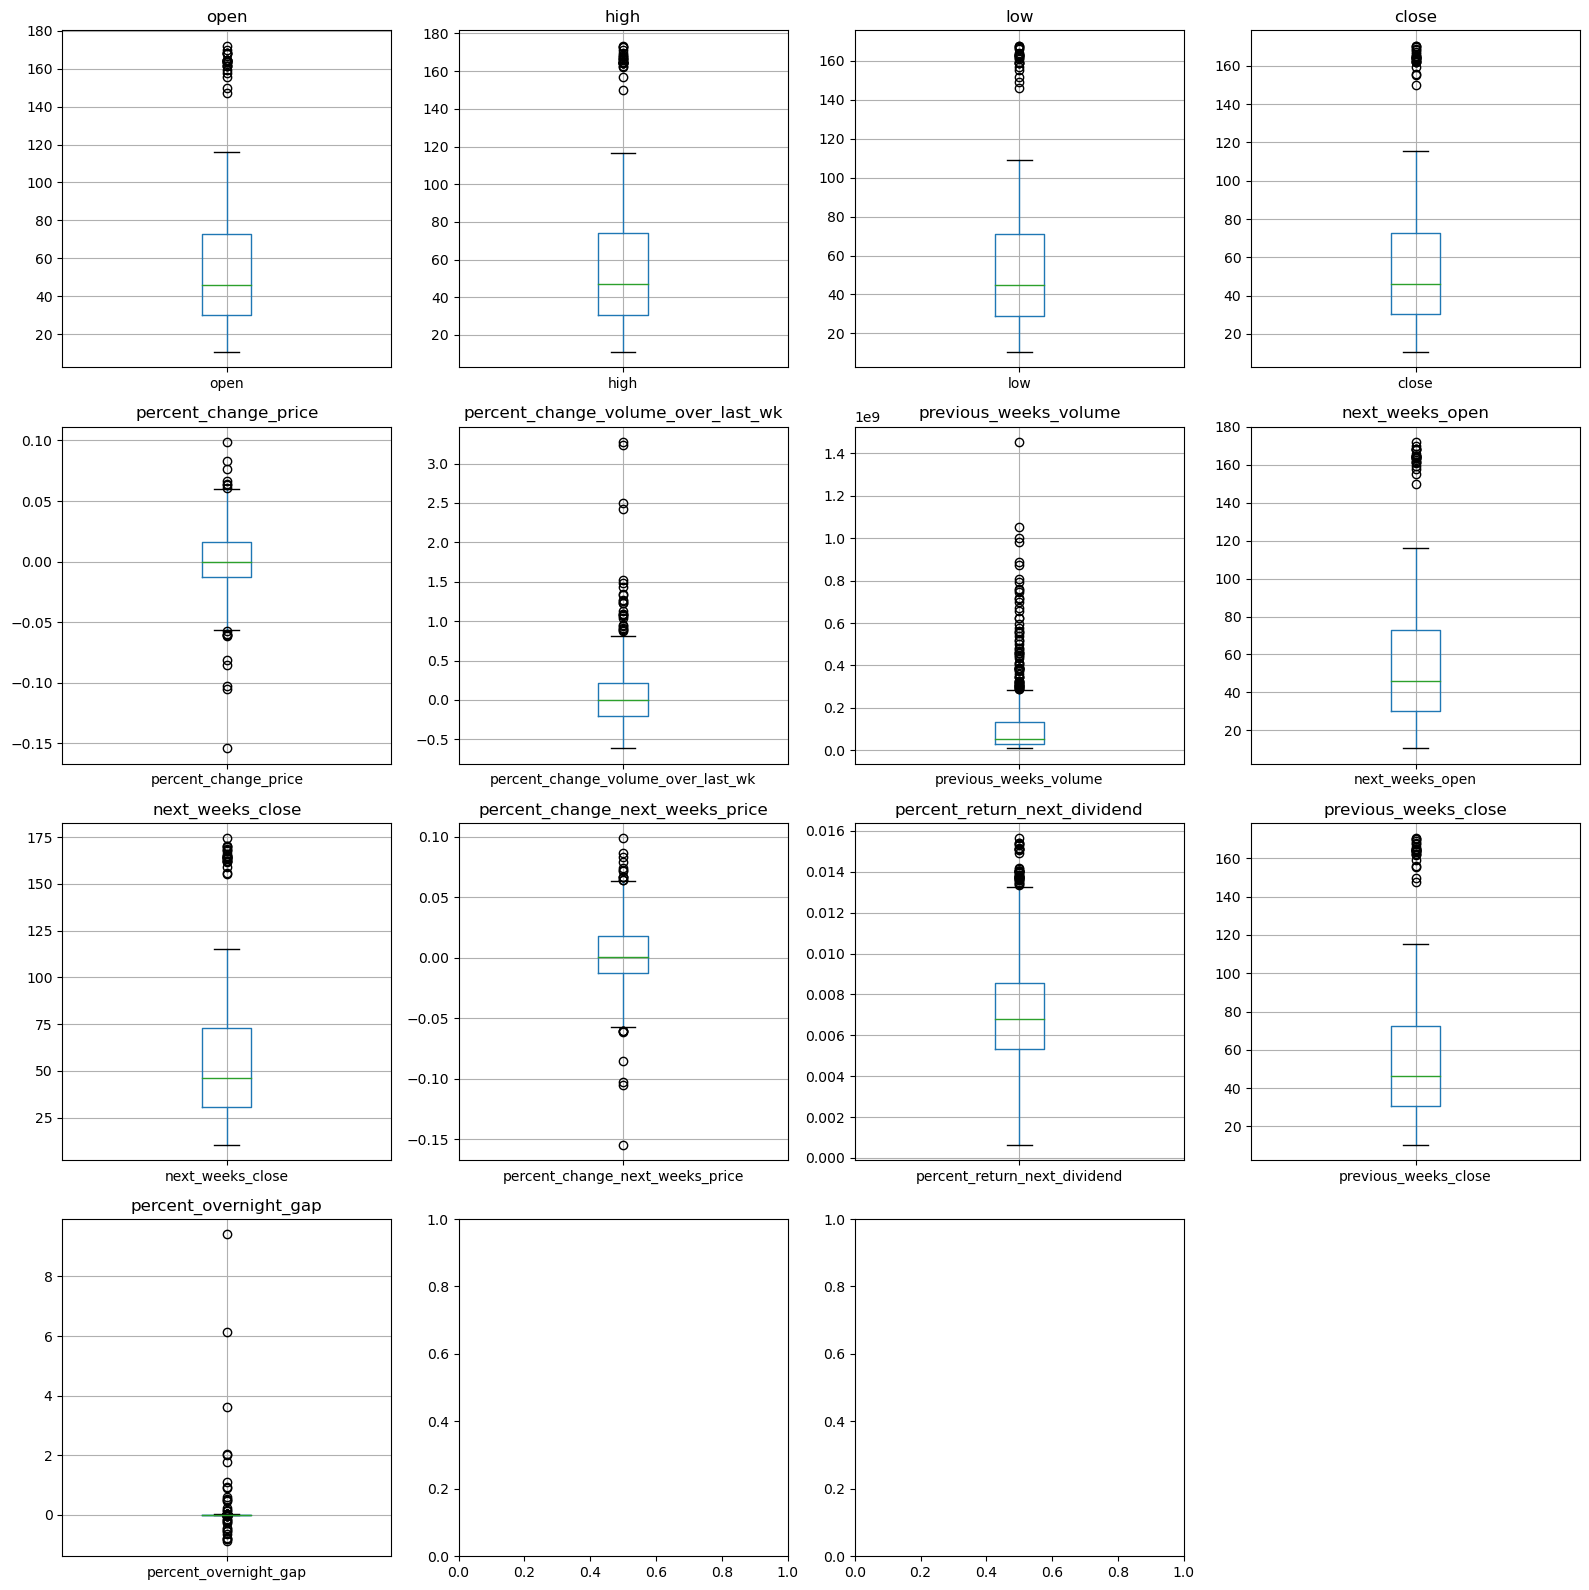

In [11]:
import math

df_float = df.select_dtypes(include=['float'])

num_variaveis = len(df_float.columns)
num_linhas = math.ceil(num_variaveis / 4)

fig, axes = plt.subplots(nrows=num_linhas, ncols=4, figsize=(16, 4*num_linhas))

if num_variaveis % 4 != 0:
    axes[-1, num_variaveis % 4:].flatten()[-1].remove()

for i, col in enumerate(df_float.columns):
    ax = axes[i // 4, i % 4]
    df_float.boxplot(column=col, ax=ax)
    ax.set_title(col)

plt.tight_layout()

plt.show()

In [124]:
random_df = data.copy()
random_df['profit'] = random_df['percent_change_price'] > 0
p = random_df.groupby('date')[['profit','percent_change_price']].mean()

In [125]:
profit = 1
for i, row in p.iterrows():
    profit = profit * (1+row['percent_change_price'])
print(profit)

1.005109330142108


In [126]:
p

,profit,percent_change_price
date,,
2011-01-14,0.833333,0.013223
2011-01-21,0.566667,0.001570
2011-01-28,0.433333,-0.005972
2011-02-04,0.800000,0.020990
2011-02-11,0.700000,0.009221
2011-02-18,0.733333,0.009944
2011-02-25,0.166667,-0.013316
2011-03-04,0.400000,-0.001749
2011-03-11,0.300000,-0.011044


-----
Several ways of seeing the returns of stocks and sectors were developed, reaching the following conclusions:
- In the case of a random choice of stocks to buy at the beginning of the week, the expected return would be 0.5% in the period.
- Of the 25 stocks represented, 17 had a positive return from beginning to end of the given periods.
- Of the 9 sectors represented, 5 obtained a positive return from the beginning to the end of the given periods.
- In 12 of the 24 periods, 50% or more of the stocks had a positive return, so the random choice of stocks in these periods assumes a positive expected value.
- Taking into account that our model will only choose stocks to buy, in 1 of the periods it will be impossible to make a profit because all the stocks had a loss.

As for the data, we arrived at the following perceptions:

- There are outliers in all features so it will be positive to try ways to deal with them.
- There are features that have very strong correlations with each other and that may be removed in the future in case the model becomes too heavy.
- It was decided to remove the lines that contained missing values (4% of the initial dataset).
- When viewing the evolution of the sector's accumulated profit, a weighted average should have been used, but I was unable to obtain the market value of some companies, so it was impossible to do so.
-----

In [13]:
# One-hot econding of "sector" column
one_hot = pd.get_dummies(df['sector'], prefix='sector')
df_encoded = pd.concat([df, one_hot], axis=1)

## Modelling
In this phase, your main goal is to develop and describe your approach to the solution of the problem. Some guidelines to help you:
* What metrics will you use to evaluate your solutions?
* What are some algorithms that can lead to good results? And why?
* Describe in detail your thought process during the development of your solution.
* Present your results.


-----


#### All model test

In [236]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from xgboost import XGBRegressor

def test_models(x_train, x_test, y_train, y_test,dates):

    pipelines = []
    pipelines.append(('ScaledLR', Pipeline([('Scaler', StandardScaler()),('LR',LinearRegression())])))
    pipelines.append(('ScaledLASSO', Pipeline([('Scaler', StandardScaler()),('LASSO', Lasso())])))
    pipelines.append(('ScaledEN', Pipeline([('Scaler', StandardScaler()),('EN', ElasticNet())])))
    pipelines.append(('ScaledKNN', Pipeline([('Scaler', StandardScaler()),('KNN', KNeighborsRegressor())])))
    pipelines.append(('ScaledDT', Pipeline([('Scaler', StandardScaler()),('DT', DecisionTreeRegressor())])))
    pipelines.append(('ScaledGBM', Pipeline([('Scaler', StandardScaler()),('GBM', GradientBoostingRegressor())])))
    pipelines.append(('ScaledXGB', Pipeline([('Scaler', StandardScaler()),('GBM', XGBRegressor(objective ='reg:squarederror'))])))

    results = []
    names = []
    for name, model in pipelines:
        
        initial_money = 100

        model.fit(x_train,y_train)
        y_preds = model.predict(x_test)
        
        df_result = pd.concat([dates.reset_index(drop=True),pd.DataFrame(y_preds, columns=['preds']), y_test.reset_index(drop=True)], axis=1)
        df_result = df_result[df_result['next_weeks_open'] < 100]
        
        max_predicted = df_result.groupby('date')['preds'].idxmax()
        df_max_predicted = df_result.loc[max_predicted]
        
        profit_pred = initial_money
        profit_real = initial_money
                
        for date in df_max_predicted['date']:
        
            stocks_number_pred = int(profit_pred/df_max_predicted.loc[df_max_predicted['date'] == date,'next_weeks_open'].values[0])
            stocks_number_real = int(profit_real/df_max_predicted.loc[df_max_predicted['date'] == date,'next_weeks_open'].values[0])
                        
            predicted_price = df_max_predicted.loc[df_max_predicted['date'] == date,'next_weeks_open'].values[0] * (1+df_max_predicted.loc[df_max_predicted['date'] == date,'preds'].values[0])
            sell_price = df_max_predicted.loc[df_max_predicted['date'] == date,'next_weeks_close'].values[0]
            invested = df_max_predicted.loc[df_max_predicted['date'] == date,'next_weeks_open'].values[0]                                                                                      
            
            profit_pred = profit_pred + stocks_number_pred * predicted_price - stocks_number_pred * invested
            profit_real = profit_real + stocks_number_real * sell_price  - stocks_number_real * invested
            
            print(f'[{name}] | {date} | Pred: {profit_pred} | Real: {profit_real}')

In [237]:
df_encoded.columns
df = df_encoded.drop(['sector'],axis=1)

In [238]:
def split(df):
    test_size = int(len(df['date'].unique()) * 0.2)
    train_size = len(df['date'].unique()) - test_size

    date_test = df['date'].unique()[(-1 *test_size):]
    date_train = df['date'].unique()[:train_size]

    train_df = df[df['date'].isin(date_train)]
    test_df = df[df['date'].isin(date_test)]
    
    return train_df, test_df

train_df, test_df = split(df)

dates = test_df[['stock','date','next_weeks_open','next_weeks_close']]
dates_train = train_df[['stock','date','next_weeks_open','next_weeks_close']]

train_df = train_df.drop(['date','stock','next_weeks_open','next_weeks_close'], axis=1)
test_df = test_df.drop(['date','stock','next_weeks_open','next_weeks_close'], axis=1)

y_train = train_df['percent_change_next_weeks_price']
x_train = train_df.drop('percent_change_next_weeks_price', axis=1)

y_test = test_df['percent_change_next_weeks_price']
x_test = test_df.drop('percent_change_next_weeks_price', axis=1)

In [239]:
test_models(x_train, x_test, y_train, y_test, dates)

[ScaledLR] | 2011-06-03 00:00:00 | Pred: 101.94213908078383 | Real: 99.33999999999999
[ScaledLR] | 2011-06-10 00:00:00 | Pred: 105.13907257327229 | Real: 100.45999999999998
[ScaledLR] | 2011-06-17 00:00:00 | Pred: 106.92897247026356 | Real: 100.49999999999999
[ScaledLR] | 2011-06-24 00:00:00 | Pred: 108.17359756281915 | Real: 109.16000000000001
[ScaledLASSO] | 2011-06-03 00:00:00 | Pred: 100.05696838781442 | Real: 96.16000000000001
[ScaledLASSO] | 2011-06-10 00:00:00 | Pred: 100.11168237334722 | Real: 92.74000000000002
[ScaledLASSO] | 2011-06-17 00:00:00 | Pred: 100.16417774076164 | Real: 96.10000000000001
[ScaledLASSO] | 2011-06-24 00:00:00 | Pred: 100.21864123715203 | Real: 102.63999999999997
[ScaledEN] | 2011-06-03 00:00:00 | Pred: 100.05696838781442 | Real: 96.16000000000001
[ScaledEN] | 2011-06-10 00:00:00 | Pred: 100.11168237334722 | Real: 92.74000000000002
[ScaledEN] | 2011-06-17 00:00:00 | Pred: 100.16417774076164 | Real: 96.10000000000001
[ScaledEN] | 2011-06-24 00:00:00 | Pre

#### FineTune XGBoost com Random Search

In [204]:
#Finetune XGBoost
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
import time
import warnings

warnings.filterwarnings("ignore", category=FutureWarning)

# A parameter grid for XGBoost
params = {
    'n_estimators':[500, 800, 1200],
    'objective': ['reg:squarederror'],
    'booster': ['gbtree', 'gblinear'],
    'eval_metric': ['rmse'],
    'eta': [i/10.0 for i in range(3,6)],
}

reg = XGBRegressor(nthread=-1)

# run randomized search
n_iter_search = 100
random_search = RandomizedSearchCV(reg, param_distributions=params,n_iter=n_iter_search, cv=5, scoring='neg_mean_squared_error')

start = time.time()
random_search.fit(x_train, y_train)
print("RandomizedSearchCV took %.2f seconds for %d candidates"
      " parameter settings." % ((time.time() - start), n_iter_search))

RandomizedSearchCV took 32.20 seconds for 100 candidates parameter settings.


In [202]:
random_search.best_params_

{'objective': 'reg:squarederror',
 'n_estimators': 500,
 'eval_metric': 'rmse',
 'eta': 0.3,
 'booster': 'gblinear'}

In [241]:
initial_money = 100

final_model = XGBRegressor(objective='reg:squarederror', n_estimators=500, eval_metric='rmse', eta=0.3, booster='gblinear')
final_model.fit(x_train,y_train)
y_preds = final_model.predict(x_test)

df_result = pd.concat([dates.reset_index(drop=True),pd.DataFrame(y_preds, columns=['preds']), y_test.reset_index(drop=True)], axis=1)
df_result = df_result[df_result['next_weeks_open'] < initial_money]

max_predicted = df_result.groupby('date')['preds'].idxmax()
df_max_predicted = df_result.loc[max_predicted]

profit_pred = initial_money
profit_real = initial_money

for date in df_max_predicted['date']:

    stocks_number_pred = int(profit_pred/df_max_predicted.loc[df_max_predicted['date'] == date,'next_weeks_open'].values[0])
    stocks_number_real = int(profit_real/df_max_predicted.loc[df_max_predicted['date'] == date,'next_weeks_open'].values[0])

    predicted_price = df_max_predicted.loc[df_max_predicted['date'] == date,'next_weeks_open'].values[0] * (1+df_max_predicted.loc[df_max_predicted['date'] == date,'preds'].values[0])
    sell_price = df_max_predicted.loc[df_max_predicted['date'] == date,'next_weeks_close'].values[0]
    invested = df_max_predicted.loc[df_max_predicted['date'] == date,'next_weeks_open'].values[0]                                                                                      

    profit_pred = profit_pred + stocks_number_pred * predicted_price - stocks_number_pred * invested
    profit_real = profit_real + stocks_number_real * sell_price  - stocks_number_real * invested

    print(f'[XGB Fine Tuned] | {date} | Pred: {profit_pred} | Real: {profit_real}')

[XGB Fine Tuned] | 2011-06-03 00:00:00 | Pred: 100.2673920109868 | Real: 99.48
[XGB Fine Tuned] | 2011-06-10 00:00:00 | Pred: 100.63770364046096 | Real: 100.19999999999999
[XGB Fine Tuned] | 2011-06-17 00:00:00 | Pred: 101.0489591670036 | Real: 99.22
[XGB Fine Tuned] | 2011-06-24 00:00:00 | Pred: 101.42096367001533 | Real: 101.22000000000001


#### Profit Metric (not finished)

In [ ]:
import xgboost as xgb

def profit_metric(preds, dtrain):
    labels = dtrain.get_label()
    df_result = pd.concat([dates_train.reset_index(drop=True),pd.DataFrame(preds, columns=['preds']), pd.DataFrame(dtrain, columns=['percent_change_next_weeks_price'])], axis=1)
    max_predicted = df_result.groupby('date')['preds'].idxmax()
    df_max_predicted = df_result.loc[max_predicted]
    profit_real = 1

    for date in df_max_predicted['date']:
        profit_real = profit_real * (1+df_max_predicted.loc[df_max_predicted['date'] == date,'percent_change_next_weeks_price'].values[0])
    return profit_real

-----
- One of the best ways to solve the problem, and according to the state of the art, would be the use of an LSTM.
- The best metric to be used would be a measure of the model's profit, as it was not developed in a timely manner, in the finetuning of XGBRegressor the mean squared error was used to punish the largest errors. To use this custom metric, we would have to use, for example, the inverse of profit, since the models generally work in an attempt to reduce the metric.
- For the choice of model, a way of measuring the final balance with the initial conditions imposed was used.
- The models that presented the best results were Linear Regression and XGBoost. After fine tuning the XGBoost it was seen that the profit was reduced, which can be explained in part due to the fact that the metric mentioned above, which measured the profit and not the error, was not being used.
- For this reason, a basic Linear Regression model was used, which gave a profit of €9.16 at the end of the 4 test periods.
-----

## Conclusions

-----
The final result, a profit of 9.16% in 4 weeks, looks like a very positive result. Comparing the evolution over time: 

- [XGB] 99.50€ 99.41€ 102.77€ 107.90€

- [LR ] 99.34€ 100.46€ 100.50€ 109.16€ 

and the average return of an arbitrary choice of stock in each period: 

- -3.3% -1.7% +0.1% -0.2%

- 96.7€ 95.06€ 95.15€ 94.96€



It's obvious that the model managed to achieve much better results not only in the total period as well as in each of the individual periods. Having said that, there would be a need to carry out the test in more periods to see if the given results were not just the target of some luck of the model.

- The use of an LSTM, as well as the treatment of outliers, can benefit the models.
- The disadvantage of using a linear regression is the fact that it is noticeable that the connection between the features and the label is not linear, that is, there will be models that will adapt better to the data than the regression.
- As mentioned, future work should involve the inclusion of neural networks such as an LSTM, better treatment of existing data, as well as the addition of more features to the dataset, such as technical indicators or macroeconomic data.
-----